In [1]:
import igl
import math
import scipy as sp
import numpy as np
import meshplot as mp
import matplotlib.pyplot as plt
import sympy
import os
root_folder = os.getcwd()

In [2]:
# v, f = igl.read_triangle_mesh(os.path.join(root_folder, "rbc.off"))

In [3]:
import meshzoo
import optimesh
v_init,f = meshzoo.icosa_sphere(16)

# class Sphere:
#     def f(self, x):
#         return 1.0 - (x[0] ** 2 + x[1] ** 2 + x[2] ** 2)

#     def grad(self, x):
#         return -2 * x
# v_init, f= optimesh.optimize_points_cells(
#     points,cells,"CVT (full)",1.0e-2,100,verbose=False,implicit_surface=Sphere(),
#     # step_filename_format="out{:03d}.vtk"
# )
rc=igl.avg_edge_length(v_init,f)*1.72
mp.jupyter()
p=mp.plot(v_init,f,shading={"wireframe":True, "wire_color": "black", #Wireframerendering
                               "width": 300, "height": 300},return_plot=True)
        #p.add_lines(v,v+1*FB, shading={"line_color": "red"})
print(len(v_init))
print(len(f))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

2562
5120


In [4]:
x1=v_init[:,0]
y1=v_init[:,1]
z1=v_init[:,2]
max(x1)

1.0

In [5]:
C_0=0.2072
C_1=2.0026
C_2=-1.1228
for i in range(len(x1)):
    rho=np.sqrt( (x1[i])**2 + (y1[i])**2 )
    if z1[i] >=0:
        z1[i]=((np.sqrt(abs((1-rho**2))))/2)*(C_0 +C_1*rho**2+C_2*rho**4)
    else:
        z1[i]=((np.sqrt(abs((1-rho**2))))/2)*(C_0 +C_1*rho**2+C_2*rho**4)*(-1)   

In [6]:
v = np.array([x1, y1,z1]).T

In [7]:
p=mp.plot(v,f,shading={"wireframe":True, "wire_color": "black", #Wireframerendering
                               "width": 300, "height": 300},return_plot=True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [8]:
npv = igl.per_vertex_normals(v, f)
K = igl.gaussian_curvature(v, f)
m = igl.massmatrix(v, f, igl.MASSMATRIX_TYPE_VORONOI)
minv = sp.sparse.diags(1 / m.diagonal())
area_voronoi=m.diagonal()
l = igl.cotmatrix(v, f) ###laplacian-operator
Hn = -minv.dot(l.dot(v))/2
H_mean = np.linalg.norm(Hn, axis=1)
sign_H = np.sign(np.sum(Hn*npv, axis=1))#*(-1)
#if (min(sign_H)<0):
#    print('H_mean changes sign')
H_mean_signed = H_mean*sign_H
Lap_H = minv.dot(l.dot(H_mean_signed))
Lap_H

array([-222.63238595, -222.63238595, -222.63238595, ...,  -66.15724412,
        -66.15724412,  -75.18206903])

In [9]:
import sympy as sm

x,y,z=sm.symbols("x y z")

In [10]:
rho=sm.sqrt(x**2 + y**2)
expression=(((sm.sqrt(1-rho**2))/2)*(C_0+(C_1*rho**2)+ C_2*rho**4))**2 -z**2
# simplify(rho)
#expression= (x**2 + y**2 +z**2 -1)
sm.simplify(expression)

-z**2 - 1.00260169*(x**2 + y**2 - 1)*(x**2 + y**2 - 0.560671127534205*(x**2 + y**2)**2 + 0.103465494856686)**2

In [11]:
fx=sm.diff(expression,x)
fy=sm.diff(expression,y)
fz=sm.diff(expression,z)

fxx=sm.diff(fx,x)
fxy=sm.diff(fx,y)
fxz=sm.diff(fx,z)

fyx=sm.diff(fy,x)
fyy=sm.diff(fy,y)
fyz=sm.diff(fy,z)

fzx=sm.diff(fz,x)
fzy=sm.diff(fz,y)
fzz=sm.diff(fz,z)


In [12]:
delf= sm.Matrix([[fx, fy, fz]]) ###gradient of explicit function
delf_T=delf.T
Hessian =sm.Matrix([[fxx, fxy, fxz], [fyx, fyy, fyz],[fzx, fzy, fzz]]) ####Hessian Matrix
Trace_Hessian=sm.trace(Hessian)
del_f_mag=sm.sqrt(delf[0]**2 +delf[1]**2+ delf[2]**2) ###Magnitude of Gradient Matrix
AA=delf*Hessian*delf_T
aa=AA.det()
Mean_Curvature=(aa - (((del_f_mag)**2)*Trace_Hessian))/(2*(del_f_mag)**3)
#Mean_Curvature=(aa - (((del_f_mag)**2)*Trace_Hessian))/(2*(del_f_mag)**3)  
#pprint(Mean_Curvature)

In [13]:
#Mean_Curvature=(aa - (((del_f_mag**2)+1)*Trace_Hessian))/(2*((del_f_mag**2)+1)**3/2)  


In [14]:
Mean_Curvature_Analytical=np.zeros(len(x1))
for i in range(len(x1)):
    Mean_Curv_Values=(Mean_Curvature.subs(x,x1[i]).subs(y,y1[i]).subs(z,z1[i]))
    Mean_Curvature_Analytical[i]=Mean_Curv_Values.evalf()
    

In [47]:
theta=np.zeros(len(x1))
Mean_Curv_A=[]
Theta_A=[]
Mean_Curv_N=[]
Lap_H_N=[]
for i in range(len(x1)):
    theta[i]=math.acos(z1[i]/np.sqrt(x1[i]**2 + y1[i]**2 + z1[i]**2 ))
    if theta[i]>=0 and theta[i]<=1.57:
        Mean_Curv_A.append(Mean_Curvature_Analytical[i])
        Theta_A.append(theta[i])
        Mean_Curv_N.append(H_mean_signed[i])
        Lap_H_N.append(Lap_H[i])

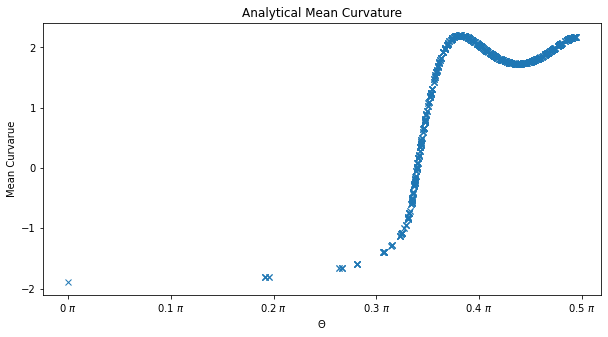

In [48]:
import matplotlib.ticker as tck
f,ax=plt.subplots(figsize=(10,5))
ax.plot((np.array(Theta_A)/np.pi),Mean_Curv_A,'x')
# #plt.legend(loc='upper left')
ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.1))
plt.title('Analytical Mean Curvature')
plt.xlabel('$ \Theta $')
plt.ylabel('Mean Curvarue')
plt.show()

In [49]:
# plt.plot(Theta_A,Mean_Curv_N_320,'.',Theta_A,Mean_Curv_A,'x',Theta_A,Mean_Curv_N_2000,'<',
#          Theta_A,Mean_Curv_N_5120,'o')

In [17]:
Theta_A_320=Theta_A
Mean_Curv_N_320=Mean_Curv_N
Mean_Curv_A_320=Mean_Curv_A
len(Mean_Curv_N_320)

73

In [34]:
Theta_A_1280=Theta_A
Mean_Curv_N_1280=Mean_Curv_N
Mean_Curv_A_1280=Mean_Curv_A
len(Mean_Curv_N_1280)

305

In [50]:
Theta_A_5120=Theta_A
Mean_Curv_N_5120=Mean_Curv_N
Mean_Curv_A_5120=Mean_Curv_A
len(Mean_Curv_N_5120)

1249

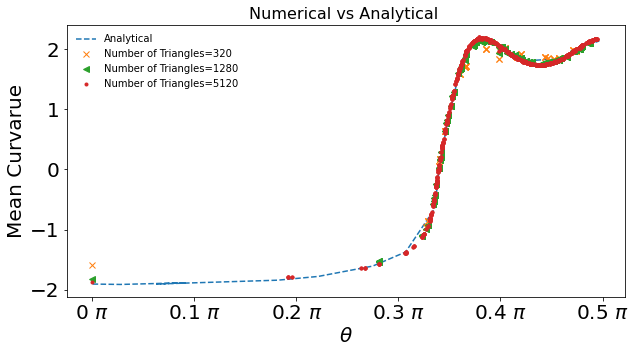

In [115]:
import matplotlib.ticker as tck
f,ax=plt.subplots(figsize=(10,5))
csfont = {'fontname':'Times New Roman'}
ax.plot(np.array(X_guck)/np.pi,Y_guck,'--', label='Analytical')
ax.plot(np.array(Theta_A_320)/np.pi,Mean_Curv_N_320,'x', label='Number of Triangles=320')
ax.plot(np.array(Theta_A_1280)/np.pi,Mean_Curv_N_1280,'<', label='Number of Triangles=1280')
ax.plot(np.array(Theta_A_5120)/np.pi,Mean_Curv_N_5120,'.',label='Number of Triangles=5120')

ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.1))
plt.xticks(fontsize=20,**csfont)
plt.yticks(fontsize=20,**csfont)


# plt.plot(time,KineticEnergy,'v-', label='Kinetic Energy',color='k')
#plt.axis([0, 800, 0, 2])
plt.legend(loc='upper left',frameon=False)
plt.title('Numerical vs Analytical ',fontsize=16,**csfont)
plt.xlabel(r'$\theta $',fontsize=20,**csfont)
plt.ylabel('Mean Curvarue',fontsize=20,**csfont)
plt.show()

In [ ]:
plt.plot(Theta_A_320,Mean_Curv_A_320,'s', label='Number of Triangles=320')
plt.plot(Theta_A_1280,Mean_Curv_A_1280,'<', label='Number of Triangles=1280')
plt.plot(Theta_A_5120,Mean_Curv_A_5120,'.',label='Number of Triangles=5120')
plt.legend(loc='upper left')
plt.xlabel('$ \Theta $')
plt.ylabel('Mean Curvarue')
plt.show()


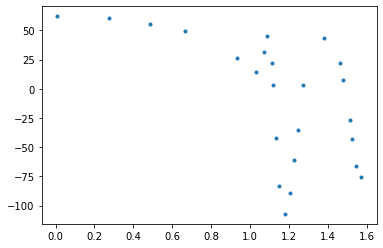

In [77]:
X=[0.007240773454152749,0.27700515012935123,0.4844110579379499,0.6661345885064185,0.934266891531196,
1.0316320975036564,1.0681797772439254,1.086401838127689,1.1104645686741268,1.1161436878993232,1.13308162992108,1.1499698641159204,1.1795501634500767,1.2032400852946417,
1.2249996865272874,1.2431140471193984,1.2702918014859295,1.3800259717227499,1.477610720597425,1.4627977881763432,
1.5109522455015871,1.5221157949632242,1.544343478232666,1.570121128807719]
Y=[62.067683349727176,60.63574775782091,55.609996650905686,49.68869245557174,26.135329780304673,14.369196771156638
,31.062981432304767,45.05322950261993,22.472950130139978,3.5096925953371,-42.54483698876868,-83.181745062723,-107.11801206201363,-89.06613010835773
,-60.629946177153926,-34.90151816817729,3.0139211565187054,43.1629690380188,7.469007692368535,21.920217717499924,
   -26.40062024171496,-43.108117729894246,-65.68786968594989,-75.1760911586548]

plt.plot(X,Y,'.')

In [52]:
import pandas as pd
data = pd.read_csv("Mean_Curv_Guckenber.csv")


In [53]:
X_guck=np.array(data.iloc[:,0])
Y_guck=np.array(data.iloc[:,1])

In [84]:
import numpy as np
import matplotlib.pyplot as plt

def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)
def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

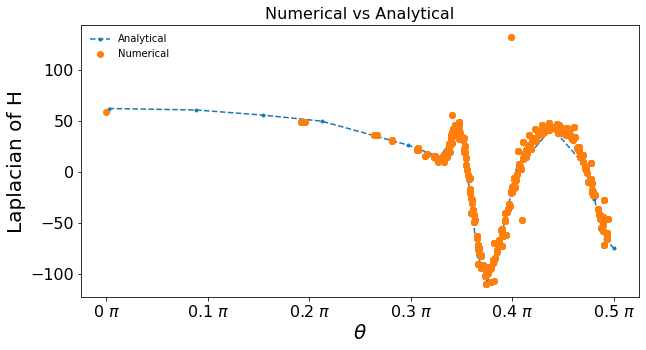

In [116]:
import matplotlib.ticker as tck
f,ax=plt.subplots(figsize=(10,5))
csfont = {'fontname':'Times New Roman'}

ax.plot(np.array(X)/np.pi,Y,'.--',label='Analytical')
ax.plot(np.array(Theta_A)/np.pi,Lap_H_N,'o',label='Numerical')
plt.legend(loc='upper left')
ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.1))

plt.legend(loc='upper left')
plt.title('Numerical vs Analytical',fontsize=16,**csfont)
plt.xlabel(r'$ \theta $',fontsize=20,**csfont)
plt.ylabel('Laplacian of H',fontsize=20,**csfont)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left',frameon=False)
plt.show()

In [ ]:
plt.plot(Theta_A,Mean_Curv_A,'.', label='Analytic ')
plt.plot(X_guck,Y_guck,'.', label='Analytic_Guck')

In [303]:


import meshio


filename='triagnle222'+'.vtk'

meshio.write_points_cells(filename, v, {"triangle": f})